In [84]:
import numpy as np
import pandas as pd
import signac
import json
from typing import Tuple
from alchemlyb.parsing.gmx import extract_u_nk
from alchemlyb.estimators import MBAR
import matplotlib.pyplot as plt

In [121]:
temperature = 298
with open("signac_project_document.json") as pipe:
    data = json.load(pipe)["free_energies"]

In [122]:
df = pd.DataFrame(data)
# kt_to_kj_mol = 2.479
# df["f_mean"] *= kt_to_kj_mol
# df["f_std"] *= kt_to_kj_mol
df.sort_values(by="solvent_name", ignore_index=True)

,solvent_name,solute_name,f_mean,f_std
0,OCO,P6,3.149828,0.028640
1,W,P6,7.403749,0.036108


In [127]:
project = signac.get_project()
project

,sp.solvent_name,sp.solute_name,sp.lambda_state,doc.system_gro,doc.system_top,doc.solute_name,doc.solute_itp,doc.system_prepared,doc.alchemical_xvg,doc.alchemical_log,doc.solute_top,doc.solute_gro,doc.solvent_top,doc.solvent_name,doc.solvent_gro,doc.solute_solvent_top,doc.solute_solvent_gro
a170ac4fcde84432823b6d5b6cd60c19,W,P6,5.0,solute_solvent_equ.gro,solute_solvent.top,P6,solute.itp,True,fep_run-5.xvg,fep_run-5.log,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fb734c57ae9565777206f54960a5123c,OCO,P6,6.0,solute_solvent_equ.gro,solute_solvent.top,P6,solute.itp,True,fep_run-6.xvg,fep_run-6.log,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3da011627721202de75c98ee7d7b1ee0,W,P6,9.0,solute_solvent_equ.gro,solute_solvent.top,P6,solute.itp,True,fep_run-9.xvg,fep_run-9.log,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b55ad9cac134725c6c357bd51ec6d2ac,W,P6,0.0,solute_solvent_equ.gro,solute_solvent.top,P6,solute.itp,True,fep_run-0.xvg,fep_run-0.log,solute.top,solute_min.gro,solvent_gen_box.top,W,solvent_prod.gro,solute_solvent.top,solute_solvent_equ.gro
5caf20eeffab1356ae64234a1827c8a2,OCO,P6,0.0,solute_solvent_equ.gro,solute_solvent.top,P6,solute.itp,True,fep_run-0.xvg,fep_run-0.log,solute.top,solute_min.gro,solvent_gen_box.top,OCO,solvent_prod.gro,solute_solvent.top,solute_solvent_equ.gro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3935f4e67dd608e87a95dd6c986ce425,W,P6,8.0,solute_solvent_equ.gro,solute_solvent.top,P6,solute.itp,True,fep_run-8.xvg,fep_run-8.log,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a7304a40fcd392c23ecf5a0e97ec9ca5,OCO,P6,9.0,solute_solvent_equ.gro,solute_solvent.top,P6,solute.itp,True,fep_run-9.xvg,fep_run-9.log,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4be2acf2727378dd0cf0fb2133bde592,OCO,P6,4.0,solute_solvent_equ.gro,solute_solvent.top,P6,solute.itp,True,fep_run-4.xvg,fep_run-4.log,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bd12850f011ed30b145264e9a549418b,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
def compute_free_energy_for_statepoint(statepoint: dict) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    jobs = project.find_jobs(statepoint)
    xvg_files = [
        job.fn(f"fep_run-{job.statepoint['lambda_state']}.xvg")
        for job in jobs
        if 'lambda_state' in job.statepoint
    ]
    u_nk_list = [extract_u_nk(f, T=temperature) for f in xvg_files]
    u_nk_combined = pd.concat(u_nk_list)
    mbar = MBAR().fit(u_nk_combined)
    # Extracting free energy differences between the first and last state
    delta_f_values = mbar.delta_f_.iloc[0, :].values
    d_delta_f_values = mbar.d_delta_f_.iloc[0, :].values
    return delta_f_values, d_delta_f_values, mbar.delta_f_.columns.values

In [125]:
delta_f_w, d_delta_f_w, states_w = compute_free_energy_for_statepoint({'solvent_name': 'W', 'solute_name': 'P6'})
delta_f_oco, d_delta_f_oco, states_oco = compute_free_energy_for_statepoint({'solvent_name': 'OCO', 'solute_name': 'P6'})

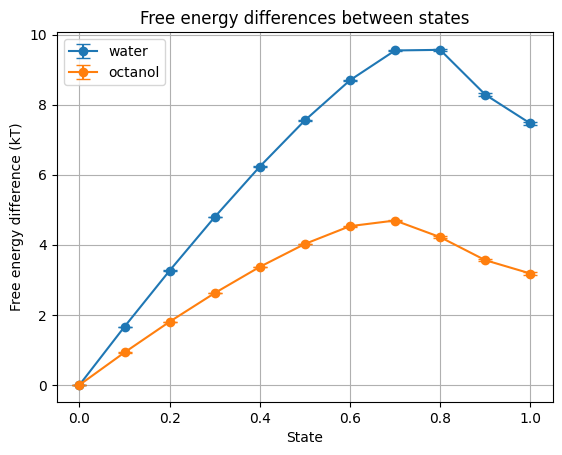

In [126]:
# Plotting free energy differences
plt.errorbar(
    states_w, delta_f_w, yerr=d_delta_f_w, marker='o', linestyle='-', capsize=5, label="water"
)
plt.errorbar(
    states_oco, delta_f_oco, yerr=d_delta_f_oco, marker='o', linestyle='-', capsize=5, label="octanol"
)

plt.xlabel('State')
plt.ylabel('Free energy difference (kT)')
plt.title('Free energy differences between states')
plt.legend()
plt.grid()

# Display the plot
plt.show()